In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm
import h5py
from scipy.interpolate import CubicSpline

# Defining functions for loading and converting data

In [5]:
parameter_dict = {
        'acc_long':     {'bstar': 198,      'rstar': 1,     'b': 198,   'r': 0.05   },
        'acc_trans':    {'bstar': 32768,    'rstar': 1,     'b': 32768, 'r': 0.04   },
        'acc_yaw':      {'bstar': 2047,     'rstar': 1,     'b': 2047,  'r': 0.1    },
        'brk_trq_elec': {'bstar': 4096,     'rstar': -1,    'b': 4098,  'r': -1     },
        'whl_trq_est':  {'bstar': 12800,    'rstar': 0.5,   'b': 12700, 'r': 1      },
        'trac_cons':    {'bstar': 80,       'rstar': 1,     'b': 79,    'r': 1      },
        'trip_cons':    {'bstar': 0,        'rstar': 0.1,   'b': 0,     'r': 1      }
    }

def convertdata(data, parameter):
    bstar = parameter['bstar']
    rstar = parameter['rstar']
    b = parameter['b']
    r = parameter['r']
    # We only convert data in the second column at idx 1 (wrt. 0-indexing), as the first column is time
    col0 = data[:,0]
    col1 = ((data[:,1]-bstar*rstar)-b)*r
    data = np.column_stack((col0, col1))
    return data


def unpack_hdf5(hdf5_file):
    with h5py.File(hdf5_file, 'r') as f:
        data = unpack_hdf5_(f)
    return data

def unpack_hdf5_(group):
    data = {}
    for key in group.keys():
        if isinstance(group[key], h5py.Group):
            data[key] = unpack_hdf5_(group[key])
        else:
            if key in parameter_dict:
                data[key] = convertdata(group[key][()], parameter_dict[key])
            else:
                data[key] = group[key][()]
    return data


# Load data

In [6]:
autopi_hh = unpack_hdf5('../data/raw/AutoPi_CAN/platoon_CPH1_HH.hdf5')
autopi_vh = unpack_hdf5('../data/raw/AutoPi_CAN/platoon_CPH1_VH.hdf5')

In [7]:
gm_data = autopi_hh['GM']['16006']['pass_1']
gm_key_to_shape = {k: v.shape for k,v in gm_data.items()}


In [8]:
p79_hh = pd.read_csv('../data/raw/ref_data/cph1_zp_hh.csv', sep=';', encoding='unicode_escape')

### We wish to find the start and end coordinate (lon, lat)

In [46]:
def find_best_start_and_end_indeces(trip: np.ndarray, section: np.ndarray, kind="l1"):
    # Find the start and end indeces of the section data that are closest to the trip data
    lat_a, lon_a = trip[:,0], trip[:,1]
    lat_b, lon_b = section[:,0], section[:,1]
    if kind == "l1":
        start_index = np.argmin(np.abs(lon_a - lon_b[0]) + np.abs(lat_a - lat_b[0]))
        end_index = np.argmin(np.abs(lon_a - lon_b[-1]) + np.abs(lat_a - lat_b[-1]))
    elif kind == "l2":
        start_index = np.argmin(np.sqrt((lon_a - lon_b[0])**2 + (lat_a - lat_b[0])**2))
        end_index = np.argmin(np.sqrt((lon_a - lon_b[-1])**2 + (lat_a - lat_b[-1])**2))

    return start_index, end_index

[26597, 175791]


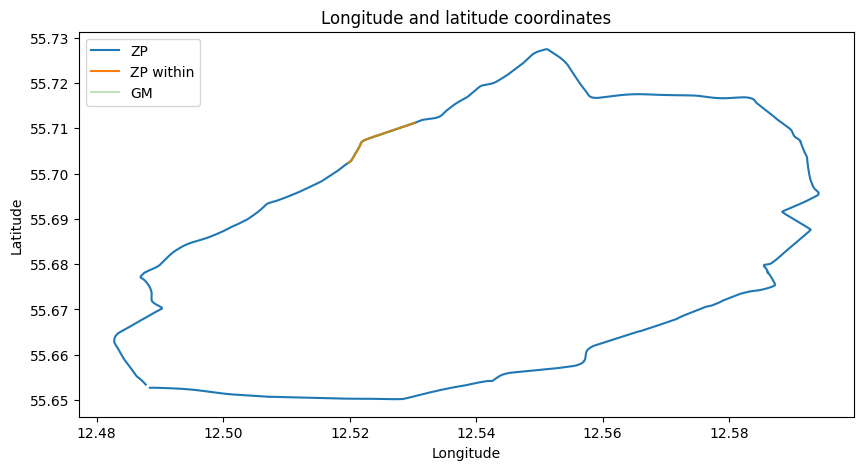

In [108]:
lon_zp_hh = p79_hh['Lon']
lat_zp_hh = p79_hh['Lat']
idx = find_best_start_and_end_indeces(p79_hh[['Lat', 'Lon']].to_numpy(), gm_data['gps'][:,1:])
# idx = [175835, 187952] <- ud fra kaspers udregning
# idx = [175791, 187993] <- ud fra l1
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(lon_zp_hh, lat_zp_hh, label='ZP')
ax.plot(lon_zp_hh[idx[0]:idx[1]+1], lat_zp_hh[idx[0]:idx[1]+1], label='ZP within')
ax.plot(gm_data['gps'][:,2], gm_data['gps'][:,1], label='GM', alpha=0.3)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Longitude and latitude coordinates')
ax.legend()
plt.show()

In [114]:
p97_hh_within = p79_hh[idx[0]:idx[1]+1].reset_index()
p97_hh_within

,index,Distance [m],Laser 1 [mm],Laser 2 [mm],Laser 3 [mm],Laser 4 [mm],Laser 5 [mm],Laser 6 [mm],Laser 7 [mm],Laser 8 [mm],...,Laser 22 [mm],Laser 23 [mm],Laser 24 [mm],Laser 25 [mm],Lat,Lon,Højde,GeoHøjde,Alt,Bearing
0,175791,17703.81763,63.354312,56.260608,47.701718,39.569244,32.707894,25.428624,15.901664,15.905193,...,-89.420401,-89.972743,-114.740336,-127.456933,55.711185,12.530209,28.700001,38.200001,66.900002,234.323435
1,175792,17703.91833,63.851952,56.076190,48.000214,39.672531,33.104864,24.319429,12.140102,16.502941,...,-89.397365,-90.132693,-114.735870,-126.691615,55.711185,12.530208,28.700001,38.200001,66.900002,234.298533
2,175793,17704.01904,63.469575,55.564309,47.518333,39.498317,32.583412,24.642667,9.451268,16.623977,...,-89.344039,-90.378151,-114.316221,-126.135284,55.711184,12.530207,28.700001,38.200001,66.900002,234.323399
3,175794,17704.11975,62.866990,54.825892,46.765553,38.802522,32.484811,22.107305,5.620698,17.063157,...,-88.912769,-90.444619,-114.629172,-125.560787,55.711184,12.530206,28.700001,38.200001,66.900002,234.320925
4,175795,17704.22046,62.467762,54.650000,47.005743,39.156882,32.914856,21.697675,12.889038,17.558855,...,-88.794995,-91.133803,-114.223469,-125.462456,55.711183,12.530204,28.700001,38.200001,66.900002,234.323364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12198,187989,18932.27168,34.074493,25.732982,21.764056,19.299873,18.185294,17.509504,17.922004,17.151516,...,-17.648210,-21.593741,-25.089496,-34.358121,55.702426,12.519808,16.900000,38.299999,55.199999,213.476478
12199,187990,18932.37239,34.172477,24.555451,20.216876,18.379917,17.022445,16.596852,17.068104,16.179164,...,-18.133573,-22.734798,-26.140191,-35.507605,55.702425,12.519807,16.900000,38.299999,55.199999,213.507034
12200,187991,18932.47310,35.265895,23.977064,19.568498,18.009419,16.658479,16.113755,16.647620,15.939195,...,-18.416546,-22.466787,-26.425649,-34.605853,55.702424,12.519806,16.900000,38.299999,55.199999,213.506405
12201,187992,18932.57381,33.626618,22.380242,18.040389,16.548349,15.224443,14.505567,14.789979,14.617816,...,-19.238966,-23.488022,-25.296229,-32.719562,55.702423,12.519805,16.900000,38.299999,55.199999,208.067148


## Define raw profile based on the lasers

In [129]:
raw_profile = lambda laser1, laser2: ((laser1 + laser2)*10e-3 / 2).to_numpy()

In [192]:
# Moving average with window size 10
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [134]:
rp_5_25 = raw_profile(p97_hh_within[' Laser 5 [mm]'], p97_hh_within[' Laser 25 [mm]'])
rp_5_25_ma = moving_average(rp_5_25, 5, 5)
rp_5_25_ma.shape

(2440,)

### Looking a distance for GM

(8006,)
(40017,)
(40008,)


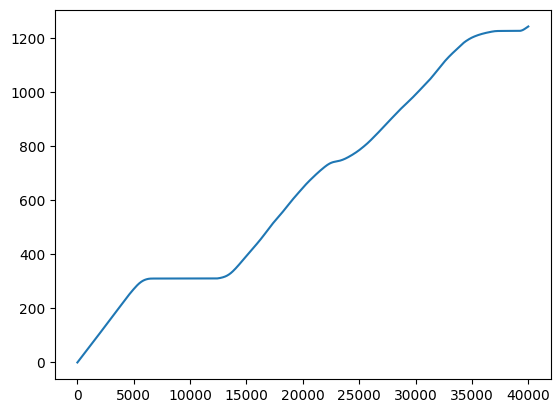

In [218]:
from scipy import signal
speed_vehicle = gm_data['spd_veh'][:,1]*0.99
print(speed_vehicle.shape)

# resample from ca. 50 Hz to 250 Hz
start = gm_data['spd_veh'][0, 0]
end = gm_data['spd_veh'][-1, 0]
time = np.linspace(start, end, int((end -start)*250))
speed_vehicle_resampled = np.interp(time, gm_data['spd_veh'][:,0], speed_vehicle)
print(speed_vehicle_resampled.shape)

# Moving average with window size 10
speed_vehicle_resampled_ma = moving_average(speed_vehicle_resampled, 10)
print(speed_vehicle_resampled_ma.shape)

# Speed signal to m/s
speed_signal = speed_vehicle_resampled_ma / 3.6

# Delta time
dt = np.diff(time)[:len(speed_signal)]

# Delta distance (cumulative sum of speed signal)
ds = np.cumsum(speed_signal * dt)

# Plot distances
plt.plot(ds)